In [1]:
import os, sys
sys.path.append("/usr/users/fsimone/tejaas")
import collections
import re
import numpy as np

pheno_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/gtex_v8_basic_phenotypes.txt"
admix_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex-admixed0.9.txt"
gteur_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
gtall_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

In [2]:
# "1" "Asian"
# "2" "Black or African American"
# "3" "White"
# "4" "American Indian or Alaska Native"
# "98" "Not Reported"
# "99" "Unknown"

In [196]:
def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
        nsample = sample
        samplenames = samplenames
        return samplenames, nsample

def write_samples(samplenames, outfile):
    with open(outfile+".sample", 'w') as outstream:
        outstream.write("ID_1 ID_2 missing father mother pheno\n")
        outstream.write("0 0 0 D D B\n")
        for sid in samplenames:
            outstream.write(f"{sid} {sid} 0 0 0 -9\n")
    with open(outfile+".list", 'w') as outstream:
        for sid in samplenames:
            outstream.write(f"{sid}\n")

In [197]:
allsamples, nall = read_samples(gtall_file)

admsamples = list()
nadm = 0
with open(admix_file) as instream:
    for line in instream:
        admsamples.append(line.strip())
        nadm += 1

In [198]:
sample_pheno_dict = dict()
with open(pheno_file) as instream:
    for line in instream:
        if line.strip() == "":
            continue
        if re.search("#", line):
            continue
        if re.search("dbGaP", line):
            header = line.strip().split()
            continue
        arr = line.strip().split("\t")
        sampleid = arr[1]
        race = arr[5]
        sample_pheno_dict[sampleid] = race

afr_samples = [x for x in allsamples if sample_pheno_dict[x] == "2"]
eur_samples = [x for x in allsamples if sample_pheno_dict[x] == "3"]
oth_samples = [x for x in allsamples if sample_pheno_dict[x] != "3" and sample_pheno_dict[x] != "2"]
print("AFR:",len(afr_samples))
print("EUR:",len(eur_samples))
print("OTH:",len(oth_samples))

AFR: 103
EUR: 715
OTH: 20


In [199]:
from collections import Counter

print(Counter([sample_pheno_dict[s] for s in eur_samples]))
print(Counter([sample_pheno_dict[s] for s in allsamples]))
print(Counter([sample_pheno_dict[s] for s in admsamples]))

Counter({'3': 715})
Counter({'3': 715, '2': 103, '1': 12, '99': 6, '4': 2})
Counter({'2': 89, '3': 17, '99': 6, '1': 3, '4': 2})


In [200]:
# Are the 17 eur samples in the admixed population in our "only eur" sample file?

counter = 0
adm_eur_samples = list()
for sid in admsamples:
    if sample_pheno_dict[sid] == '3':
        if sid in eur_samples:
            adm_eur_samples.append(sid)
            counter += 1
print(f"{counter} of 17 admixed samples are in our EUR sample file")

eur_samples_noadm = [x for x in eur_samples if x not in adm_eur_samples]

17 of 17 admixed samples are in our EUR sample file


In [201]:
print(len(eur_samples_noadm), len(eur_samples))
write_samples(eur_samples_noadm, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM")

698 715


In [202]:
write_samples(afr_samples, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_afr")
write_samples(eur_samples, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur")

In [203]:
print(len(afr_samples), len(eur_samples), len(afr_samples+eur_samples))
write_samples(afr_samples+eur_samples, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_afr_only")

103 715 818


In [204]:
print(len(oth_samples))
write_samples(oth_samples, "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_oth")

20


# Read some SNPs from the VCF files

In [13]:
sys.path.append("../../utils/")
import readgt

# Try to calculate Fst on 1KG data
* should match saikat's values calculated with vcftools

In [309]:
# Use real genotype
chrm=1
f_vcf = "/cbscratch/franco/from_saikat/1KG/hg38/ALL.chr{:d}_GRCh38.genotypes.20170504.vcf.gz".format(chrm)
samplefile = None
gtfull1kg, snpinfos1kg, gt_donors1kg = readgt.read_vcf(f_vcf, 0, 10000, samplefile=samplefile)

In [310]:
# read 1KG sample ethnicity
# AFR, African
# AMR, Ad Mixed American
# EAS, East Asian
# EUR, European
# SAS, South Asian
file_1kg_metadata = "/cbscratch/franco/from_saikat/1KG/integrated_call_samples_v3.20130502.ALL.panel"
samples_1kg = collections.defaultdict(list)
with open(file_1kg_metadata) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        samples_1kg[arr[2]].append(arr[0])

In [311]:
print(f"Eur: {len(samples_1kg['EUR'])}")
print(f"Afr: {len(samples_1kg['AFR'])}")
eur_ix = [gt_donors1kg.index(i) for i in samples_1kg["EUR"]]
afr_ix = [gt_donors1kg.index(i) for i in samples_1kg["AFR"]]

eur_n = len(samples_1kg['EUR'])
afr_n = len(samples_1kg['AFR'])
all_n = afr_n + eur_n

eur_gt1kg = gtfull1kg[:, eur_ix]
afr_gt1kg = gtfull1kg[:, afr_ix]
all_gt1kg = np.hstack((eur_gt1kg, afr_gt1kg))
print(all_gt1kg.shape)

snp_info1kg, dosage1kg = readgt.filter_snps(snpinfos1kg, all_gt1kg)
eur_gt1kg = dosage1kg[:, :eur_n]
afr_gt1kg = dosage1kg[:, eur_n:]
all_gt1kg = np.hstack((eur_gt1kg, afr_gt1kg))
print(dosage1kg.shape, afr_gt1kg.shape, eur_gt1kg.shape)

Eur: 503
Afr: 661
(10000, 1164)
Removed 477 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of unknown allele symbol
Removed 1365 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 6895 SNPs because of low MAF < 0.01
Removed 66 SNPs because of low MAF (current)
(1197, 1164) (1197, 661) (1197, 503)


In [312]:
# for snpi,snp in enumerate(snp_info1kg):
#     maf_all = sum(all_gt1kg[snpi,:] / 2 / len(all_gt1kg[snpi,:]))
#     maf_eur = sum(eur_gt1kg[snpi,:] / 2 / len(eur_gt1kg[snpi,:]))
#     maf_afr = sum(afr_gt1kg[snpi,:] / 2 / len(afr_gt1kg[snpi,:]))

#     c_eur = eur_n / all_n
#     c_afr = afr_n / all_n
#     p_all = maf_all*(1-maf_all)

#     # print(maf_all, maf_eur, maf_afr)

#     Fst = (p_all  - ( c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) ) ) / p_all
#     print(Fst)

In [313]:
def calc_simple_fst_power(pops_gt, pops): 
    
    nsnps = pops_gt[pops[0]].shape[0]
    for j in range(1, len(pops)):
        if nsnps != pops_gt[pops[j]].shape[0]:
            print("SNP numbers differ between populations")
            raise
    
    power_list = list()
    fst_list = list()
    # all_gt = np.hstack((eur_gt1kg, afr_gt1kg))
    all_gt = np.hstack(tuple([pops_gt[x] for x in pops]))
    all_n  = all_gt.shape[1] # size of total population
    for snpi in range(all_gt.shape[0]):
        # maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
        # maf_eur = sum(eur_gt[snpi,:] / 2 / len(eur_gt[snpi,:]))
        # maf_afr = sum(afr_gt[snpi,:] / 2 / len(afr_gt[snpi,:]))
        if np.all(all_gt[snpi,:] == all_gt[snpi,0]):
            print("Warning!")
        maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
        maf_pops = [sum(pops_gt[x][snpi,:] / 2 / len(pops_gt[x][snpi,:])) for x in pops]
        
        # maf_all = sum(maf_pops) / len(maf_pops)

        c_pops = [pops_gt[x].shape[1]/all_n for x in pops]
        #c_eur = eur_n / all_n
        #c_afr = afr_n / all_n
        
        p_all = maf_all*(1-maf_all)
        sum_elems = np.array([c_pops[i]*maf_pops[i]*(1-maf_pops[i]) for i in range(len(pops))])
        sum_p = np.sum(sum_elems)
        power = all_n * sum_p # (c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) )
        
        Fst = (p_all  - sum_p ) / p_all
        power_list.append(power)
        fst_list.append(Fst)
    return fst_list, power_list


In [314]:
def get_gt_count(dosage, allele='ref'):
    n_het = dosage.count(1)
    if allele == "ref":
        n_hom = dosage.count(0)
    if allele == "alt":
        n_hom = dosage.count(2)
    return n_hom, n_het

def weir_cockerman_fst(pops_gt, pops=["eur", "afr"], alleles=["ref", "alt"]):
    
    fst_list = list()
    nsnps = pops_gt[pops[0]].shape[0]
    if nsnps != pops_gt[pops[1]].shape[0]:
        print("SNP numbers differ between populations")
        raise
        
    for snpi in range(nsnps):
        n_pops = len(pops)
        n_alleles = len(alleles)
        n = np.zeros(n_pops)
        p = np.zeros((n_pops, n_alleles))
        pbar = np.zeros(n_alleles)
        hbar = np.zeros(n_alleles)
        ssqr = np.zeros(n_alleles)

        nbar = 0.0
        sum_nsqr = 0.0
        n_sum = 0.0
        for pop in range(n_pops):
            for al in range(n_alleles):
                n_hom, n_het = get_gt_count(list(pops_gt[pops[pop]][snpi,:]), allele=alleles[al])
                n[pop] += n_hom + 0.5*n_het
                p[pop,al] = n_het + 2*n_hom

                nbar += n[pop]
                pbar[al] += p[pop][al]
                hbar[al] += n_het
            for al in range(n_alleles):
                p[pop,al] /= 2.0*n[pop]

            sum_nsqr += (n[pop] * n[pop])

        n_sum = sum(n)
        nbar  = n_sum / n_pops

        for al in range(n_alleles):
            pbar[al] /= (n_sum * 2.0)
            hbar[al] /= n_sum

        for al in range(n_alleles):
            for pop in range(n_pops):
                ssqr[al] += n[pop]*(p[pop,al] - pbar[al])*(p[pop,al] - pbar[al])
            ssqr[al] /= (n_pops-1)*nbar
        nc = (n_sum - (sum_nsqr / n_sum)) / (n_pops - 1)

        snp_Fst = np.zeros(n_alleles)
        a = np.zeros(n_alleles)
        b = np.zeros(n_alleles)
        c = np.zeros(n_alleles)
        r = n_pops
        sum_a = 0.0
        sum_all = 0.0
        for al in range(n_alleles):
            a[al] = (ssqr[al] - ( pbar[al]*(1.0-pbar[al]) - (((r-1.0)*ssqr[al])/r) - (hbar[al]/4.0) )/(nbar-1.0))*nbar/nc;
            b[al] = (pbar[al]*(1.0-pbar[al]) - (ssqr[al]*(r-1.0)/r) - hbar[al]*( ((2.0*nbar)-1.0) / (4.0*nbar) ))*nbar / (nbar-1.0) ;
            c[al] = hbar[al] / 2.0;
            snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);

            if not np.all([np.isnan(a[al]),np.isnan(b[al]),np.isnan(c[al])]):
                sum_a += a[al]
                sum_all += a[al] + b[al] + c[al]
        fst = sum_a/sum_all
        fst_list.append(fst)
    return fst_list

In [315]:
pops_gt = dict()
pops_gt["eur"] = eur_gt1kg
pops_gt["afr"] = afr_gt1kg
pops = ["eur", "afr"]
alleles = ["ref", "alt"]
fsts_1kg, power_1kg = calc_simple_fst_power(pops_gt, pops)
weir_fsts_1kg = weir_cockerman_fst(pops_gt, pops, alleles)

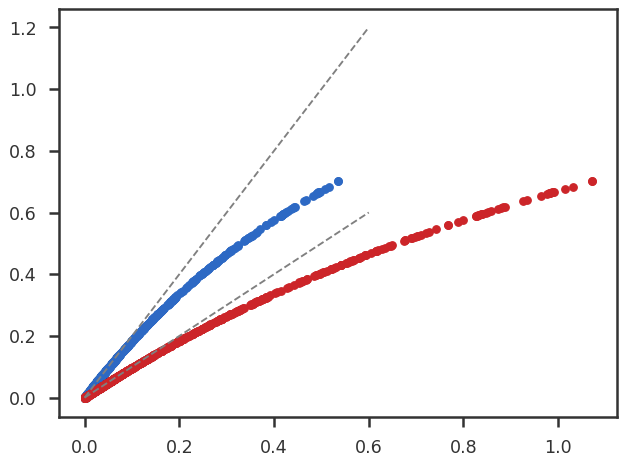

In [316]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_1kg, weir_fsts_1kg)
ax1.scatter(2*np.array(fsts_1kg), weir_fsts_1kg)
ax1.plot([0,0.6],[0,.6], color="gray", linestyle="--")
ax1.plot([0,0.6],[0,1.2], color="gray", linestyle="--")
plt.show()

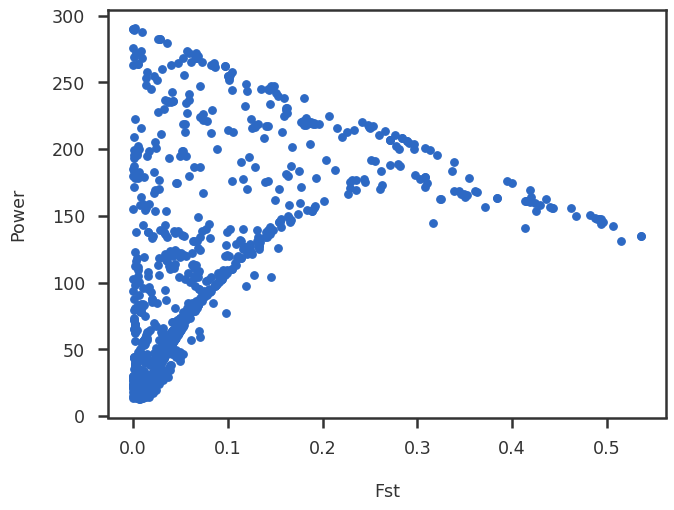

In [317]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.scatter(fsts_1kg, power_1kg)
ax1.set_xlabel("Fst")
ax1.set_ylabel("Power")
plt.show()

## Try the same on GTEx data

In [286]:
# Use real genotype
chrm=9
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
# f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/ldpruned/GTEX_v8.SHAPEIT2_chr1.ldpruned.vcf.gz"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM.sample"
# samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
samplefile = None
gtfull, snpinfos, gt_donors = readgt.read_vcf(f_vcf, 0, 20000, samplefile=samplefile)

In [290]:
print(f"Eur no adm: {len(eur_samples_noadm)}")
print(f"Eur: {len(eur_samples)}")
print(f"Afr: {len(afr_samples)}")
print(f"Genotyped samples: {len(gt_donors)}")
eur_ix = [gt_donors.index(i) for i in eur_samples]
afr_ix = [gt_donors.index(i) for i in afr_samples]
oth_ix = [gt_donors.index(i) for i in oth_samples]


gt_eur_samples = [gt_donors[i] for i in eur_ix]
gt_afr_samples = [gt_donors[i] for i in afr_ix]
gt_oth_samples = [gt_donors[i] for i in oth_ix]


eur_n = len(gt_eur_samples)
afr_n = len(gt_afr_samples)
oth_n = len(gt_oth_samples)

print(f"Genotyped EUR samples: {eur_n}")
print(f"Genotyped AFR samples: {afr_n}")
print(f"Genotyped OTH samples: {oth_n}")

eur_gt = gtfull[:, eur_ix]
afr_gt = gtfull[:, afr_ix]
oth_gt = gtfull[:, oth_ix]

print(eur_gt.shape, afr_gt.shape, oth_gt.shape)
# all_gt = np.hstack((eur_gt, afr_gt))
# print(all_gt.shape)

# snp_info, dosage = readgt.filter_snps(snpinfos, all_gt)
# eur_gt = dosage[:, :eur_n]
# afr_gt = dosage[:, eur_n:]
# all_gt = np.hstack((eur_gt, afr_gt))
# print(dosage.shape, eur_gt.shape, afr_gt.shape)

Eur no adm: 698
Eur: 715
Afr: 103
Genotyped samples: 838
Genotyped EUR samples: 715
Genotyped AFR samples: 103
Genotyped OTH samples: 20
(20000, 715) (20000, 103) (20000, 20)


In [292]:
# for i, snp in enumerate(snp_info):
#     print(snp.varid, weir_fsts_gtex[i], fsts_gtex[i])

# Check if 2 and 3 population fst calculations work

In [303]:
# Load the data calculated with vcftools

ext_fst_file_2pop = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_v8_SHAPEIT2_EUR-AFR-chr{chrm}.weir.fst"
ext_fst_2pop = dict()
with open(ext_fst_file_2pop) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        ext_fst_2pop[int(arr[1])] = float(arr[2])
        

ext_fst_file_3pop = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_v8_SHAPEIT2_EUR-AFR-OTH-chr{chrm}.weir.fst"
ext_fst_3pop = dict()
with open(ext_fst_file_3pop) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        ext_fst_3pop[int(arr[1])] = float(arr[2])

In [304]:
# Prepare data for 2 population calculations

pops_gt = dict()
pops_gt["eur"] = eur_gt
pops_gt["afr"] = afr_gt
pops = ["eur", "afr"]
alleles = ["ref", "alt"]
fsts_gtex, power_gtex = calc_simple_fst_power(pops_gt, pops)
weir_fsts_gtex = weir_cockerman_fst(pops_gt, pops, alleles)

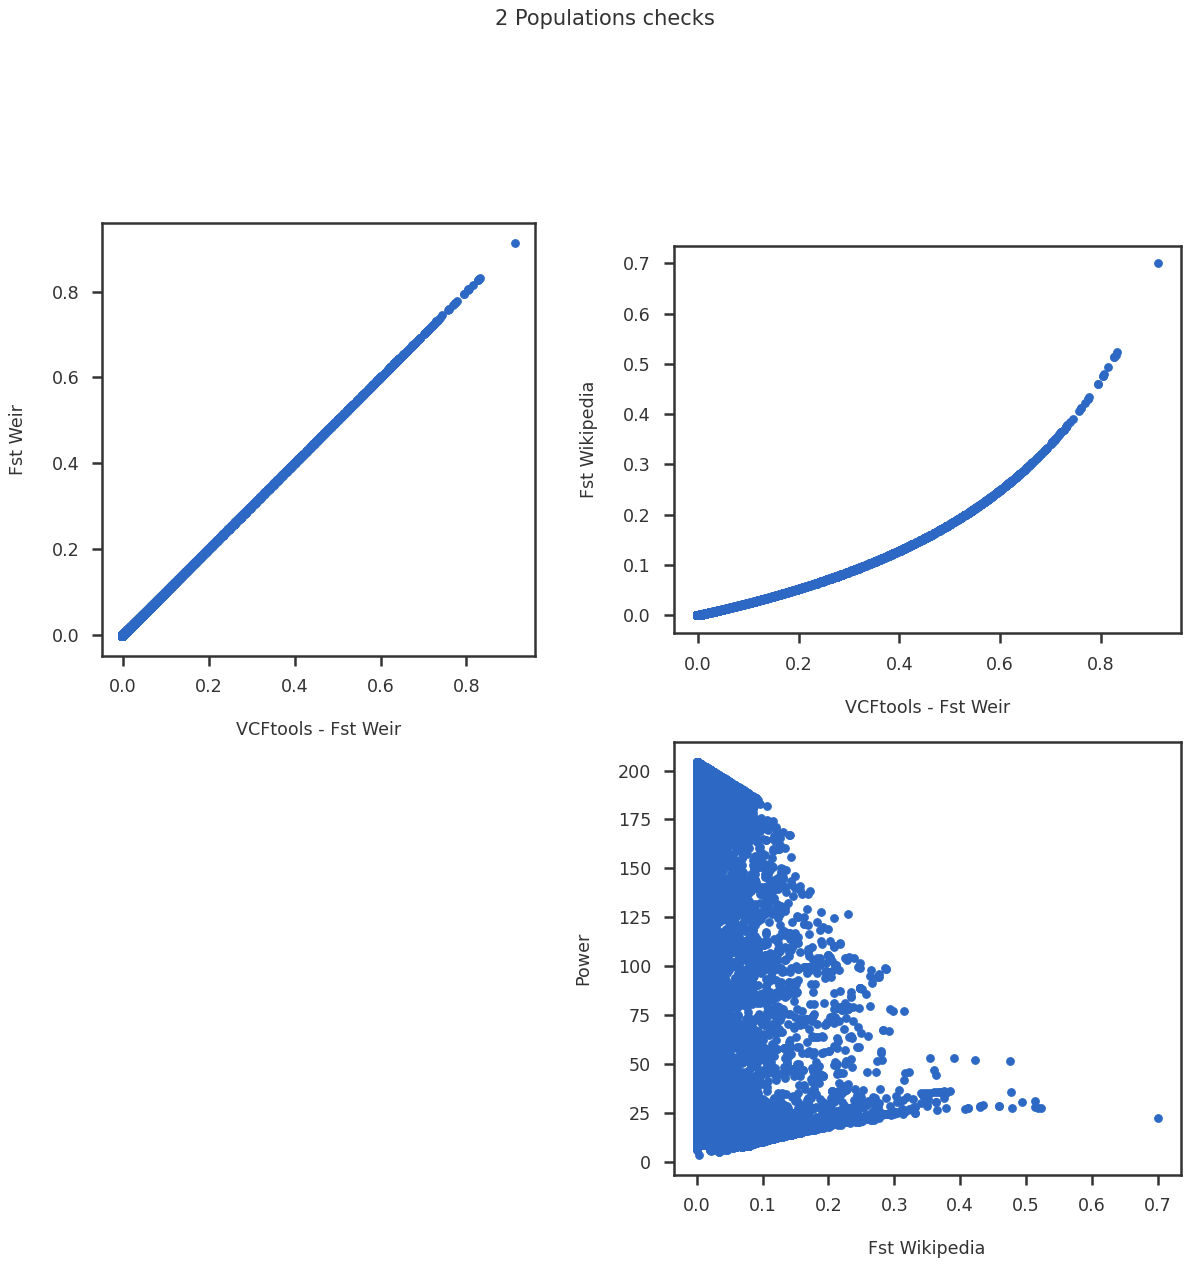

In [305]:
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

x = list()
y = list()
yy = list()
z = list()
for i, snp in enumerate(snpinfos):
    pos = int(snp.varid.split("_")[1])
    x.append(ext_fst_2pop[pos])
    y.append(weir_fsts_gtex[i])
    yy.append(fsts_gtex[i])
    z.append(power_gtex[i])
    # print(snp.varid, weir_fsts_gtex[i], fsts_gtex[i], ext_fst[pos])
    
fig = plt.figure(figsize=(16,14))
fig.suptitle("2 Populations checks", y=1.05)
ax1 = fig.add_subplot(221)
ax1.scatter(x, y)
ax1.set_xlabel("VCFtools - Fst Weir")
ax1.set_ylabel("Fst Weir")

ax2 = fig.add_subplot(222)
ax2.scatter(x, yy)
ax2.set_xlabel("VCFtools - Fst Weir")
ax2.set_ylabel("Fst Wikipedia")

# ax3 = fig.add_subplot(223)
# ax3.scatter(x, z)
# ax3.set_xlabel("VCFtools - Fst Weir")
# ax3.set_ylabel("Power")

ax4 = fig.add_subplot(224)
ax4.scatter(yy, z)
ax4.set_xlabel("Fst Wikipedia")
ax4.set_ylabel("Power")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()


In [306]:
# Prepare data for 3 population calculations

pops_gt = dict()
pops_gt["eur"] = eur_gt
pops_gt["afr"] = afr_gt
pops_gt["oth"] = oth_gt
pops = ["eur", "afr", "oth"]
alleles = ["ref", "alt"]
fsts_gtex, power_gtex = calc_simple_fst_power(pops_gt, pops)
weir_fsts_gtex = weir_cockerman_fst(pops_gt, pops, alleles)

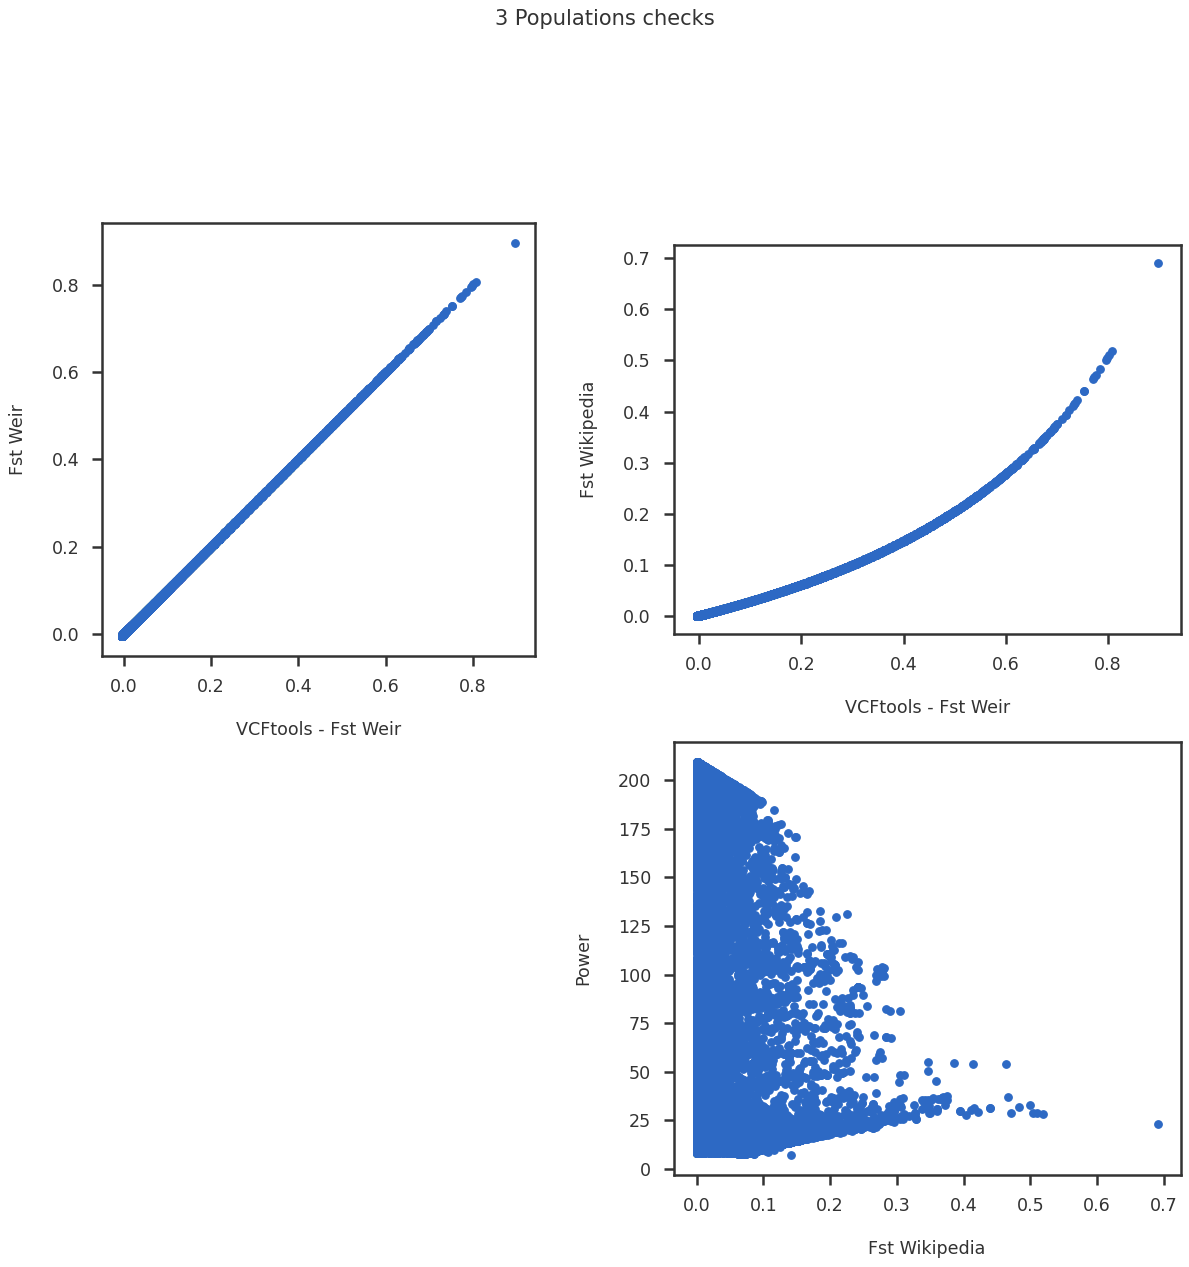

In [307]:
x = list()
y = list()
yy = list()
z = list()
for i, snp in enumerate(snpinfos):
    pos = int(snp.varid.split("_")[1])
    x.append(ext_fst_3pop[pos])
    y.append(weir_fsts_gtex[i])
    yy.append(fsts_gtex[i])
    z.append(power_gtex[i])
    # print(snp.varid, weir_fsts_gtex[i], fsts_gtex[i], ext_fst[pos])
    
fig = plt.figure(figsize=(16,14))
fig.suptitle("3 Populations checks", y=1.05)
ax1 = fig.add_subplot(221)
ax1.scatter(x, y)
ax1.set_xlabel("VCFtools - Fst Weir")
ax1.set_ylabel("Fst Weir")

ax2 = fig.add_subplot(222)
ax2.scatter(x, yy)
ax2.set_xlabel("VCFtools - Fst Weir")
ax2.set_ylabel("Fst Wikipedia")

# ax3 = fig.add_subplot(223)
# ax3.scatter(x, z)
# ax3.set_xlabel("VCFtools - Fst Weir")
# ax3.set_ylabel("Power")

ax4 = fig.add_subplot(224)
ax4.scatter(yy, z)
ax4.set_xlabel("Fst Wikipedia")
ax4.set_ylabel("Power")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()


## Same check for tissue specific Fst

In [219]:
# read the samples for each tissue
import utils

tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)

expr_dir = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms"
expr_file = os.path.join(expr_dir, "{:s}_tpms_qcfilter.txt")

tissue_samples = dict()
for tissue in tshorts:
    with open(expr_file.format(tissue)) as instream:
        samplenames = instream.readline().strip().split("\t")[1:]
        tissue_samples[tissue] = samplenames

In [279]:
# Use real genotype
chrm=9
f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
samplefile = None
gtfull, snpinfos, gt_donors = readgt.read_vcf(f_vcf, 0, 20000, samplefile=samplefile)

In [280]:
def match_samples(gt_donors, expr_donors):
    common  = [x for x in gt_donors if x in expr_donors]
    vcfmask = [gt_donors.index(x) for x in common]
    if len(common) != len(expr_donors):
        print("samples ids mismatch")
    return vcfmask, common

def find_ancestry_3pop(samples, sample_pheno_dict):
    ix_eur = list()
    ix_afr = list()
    ix_oth = list()
    for i,sid in enumerate(samples):
        if sample_pheno_dict[sid] == '2':
            ix_afr.append(i)
        elif sample_pheno_dict[sid] == '3':
            ix_eur.append(i)
        else:
            ix_oth.append(i)
    return ix_eur, ix_afr, ix_oth

gw_tissue_fst_2pop = collections.defaultdict(dict)
gw_tissue_fst_3pop = collections.defaultdict(dict)
select_tissues = ["sse"]
for tissue in select_tissues:
    vcfmask, sampids = match_samples(gt_donors, tissue_samples[tissue])
    tissue_gt = gtfull[:, vcfmask]
    alleles = ["ref", "alt"]
    ix_eur, ix_afr, ix_oth = find_ancestry_3pop(sampids, sample_pheno_dict)
    print(f"{tissue}: {len(ix_eur)} EUR, {len(ix_afr)} AFR, {len(ix_oth)} OTHER, Total: {len(vcfmask)} {tissue_gt.shape}")
    for snpi, snp in enumerate(snpinfos):
        # print(snp.rsid)
        chrm = int(snp.varid.split("_")[0][3:])
        snp_dosage = tissue_gt[snpi,:]
        pops_gt = dict()
        pops = ["eur", "afr", "oth"]
        pops_gt["eur"] = np.array([snp_dosage[i] for i in ix_eur]).reshape(1,-1)
        pops_gt["afr"] = np.array([snp_dosage[i] for i in ix_afr]).reshape(1,-1)
        pops_gt["oth"] = np.array([snp_dosage[i] for i in ix_oth]).reshape(1,-1)
        fsts_gtex, power_gtex = calc_simple_fst_power(pops_gt, pops)
        weir_fsts_gtex = weir_cockerman_fst(pops_gt, pops, alleles)
        gw_tissue_fst_3pop[tissue][snp.varid] = [weir_fsts_gtex[0], fsts_gtex[0], power_gtex[0]]
        
        pops_gt = dict()
        pops = ["eur", "afr"]
        pops_gt["eur"] = np.array([snp_dosage[i] for i in ix_eur]).reshape(1,-1)
        pops_gt["afr"] = np.array([snp_dosage[i] for i in ix_afr]).reshape(1,-1)
        fsts_gtex, power_gtex = calc_simple_fst_power(pops_gt, pops)
        weir_fsts_gtex = weir_cockerman_fst(pops_gt, pops, alleles)
        gw_tissue_fst_2pop[tissue][snp.varid] = [weir_fsts_gtex[0], fsts_gtex[0], power_gtex[0]]
        # print(teqtl_tissue_fst[tissue][snp.rsid])

sse: 518 EUR, 73 AFR, 14 OTHER, Total: 605 (20000, 605)


In [281]:
# Read external fst file
tissue = select_tissues[0]

tissue_ext_fst_file_2pop = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/{tissue}/GTEx_v8_SHAPEIT2_EUR-AFR-chr{chrm}.weir.fst"
tissue_ext_fst_2pop = dict()
with open(tissue_ext_fst_file_2pop) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        tissue_ext_fst_2pop[int(arr[1])] = float(arr[2])
        

tissue_ext_fst_file_3pop = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/{tissue}/GTEx_v8_SHAPEIT2_EUR-AFR-OTH-chr{chrm}.weir.fst"
tissue_ext_fst_3pop = dict()
with open(tissue_ext_fst_file_3pop) as instream:
    next(instream)
    for line in instream:
        arr = line.strip().split()
        tissue_ext_fst_3pop[int(arr[1])] = float(arr[2])

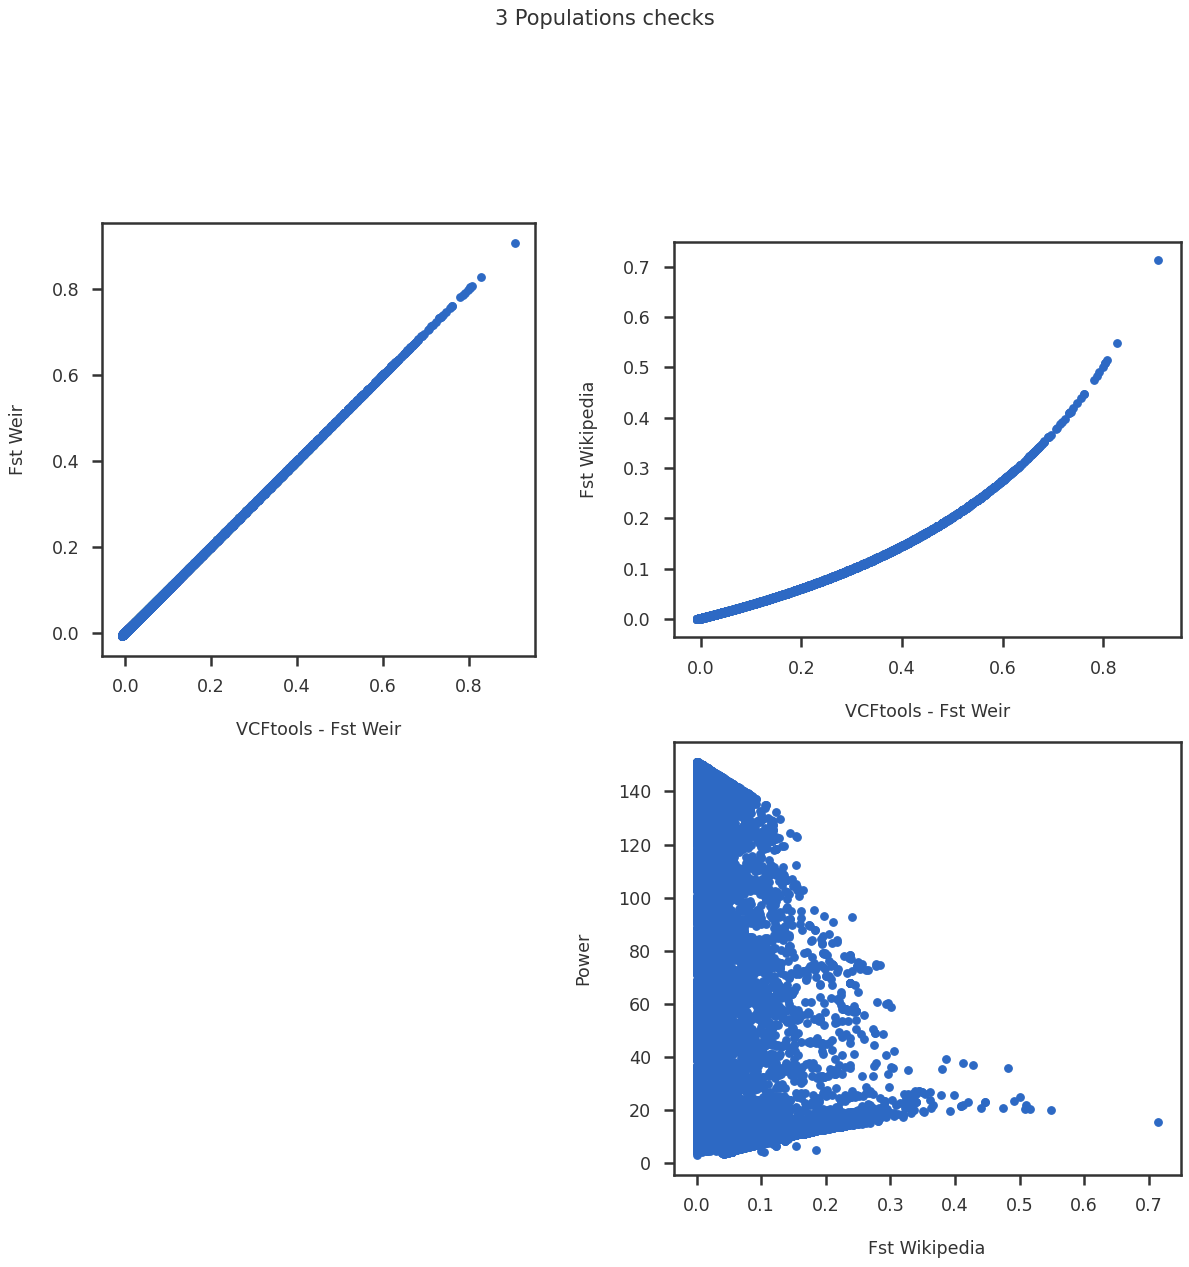

In [285]:
x = list()
y = list()
yy = list()
z = list()
for varid in gw_tissue_fst_3pop[tissue]:
    pos = int(varid.split("_")[1])
    if pos in tissue_ext_fst_3pop:
        x.append(tissue_ext_fst_3pop[pos])
        # print(varid, tissue_ext_fst_3pop[pos], gw_tissue_fst_3pop[tissue][varid])
        y.append(gw_tissue_fst_3pop[tissue][varid][0])  #weir
        yy.append(gw_tissue_fst_3pop[tissue][varid][1]) #fst 
        z.append(gw_tissue_fst_3pop[tissue][varid][2])  #power 
    
fig = plt.figure(figsize=(16,14))
fig.suptitle("3 Populations checks", y=1.05)
ax1 = fig.add_subplot(221)
ax1.scatter(x, y)
ax1.set_xlabel("VCFtools - Fst Weir")
ax1.set_ylabel("Fst Weir")

ax2 = fig.add_subplot(222)
ax2.scatter(x, yy)
ax2.set_xlabel("VCFtools - Fst Weir")
ax2.set_ylabel("Fst Wikipedia")

# ax3 = fig.add_subplot(223)
# ax3.scatter(x, z)
# ax3.set_xlabel("VCFtools - Fst Weir")
# ax3.set_ylabel("Power")

ax4 = fig.add_subplot(224)
ax4.scatter(yy, z)
ax4.set_xlabel("Fst Wikipedia")
ax4.set_ylabel("Power")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()


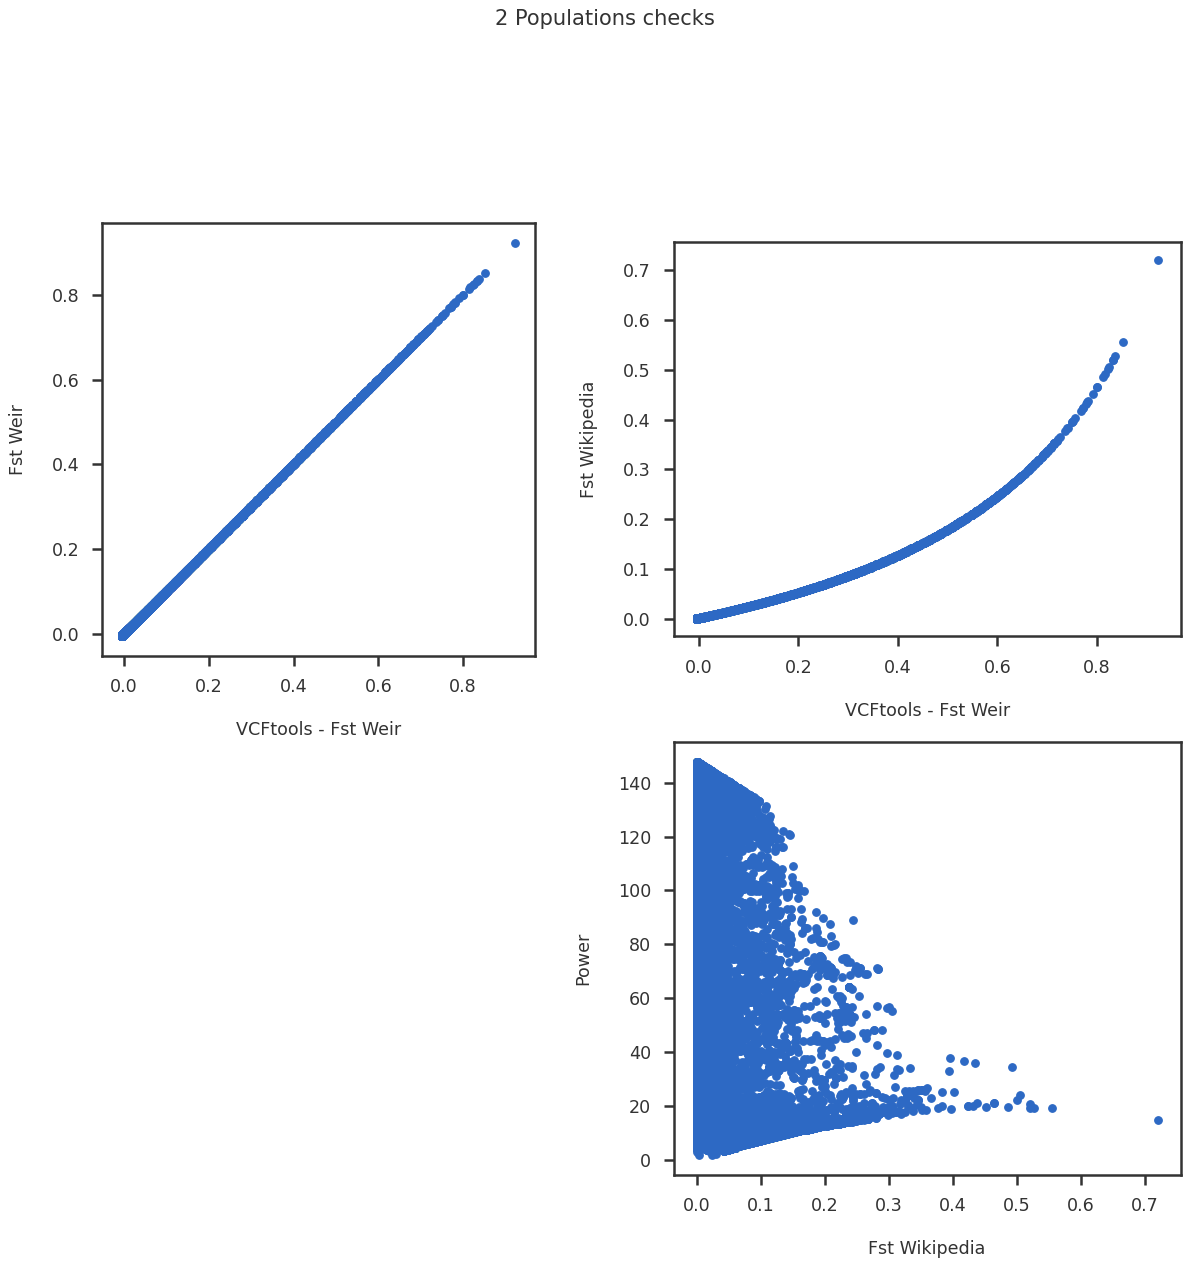

In [308]:
x = list()
y = list()
yy = list()
z = list()
for varid in gw_tissue_fst_2pop[tissue]:
    pos = int(varid.split("_")[1])
    if pos in tissue_ext_fst_2pop:
        x.append(tissue_ext_fst_2pop[pos])
        # print(varid, tissue_ext_fst_3pop[pos], gw_tissue_fst_3pop[tissue][varid])
        y.append(gw_tissue_fst_2pop[tissue][varid][0])  #weir
        yy.append(gw_tissue_fst_2pop[tissue][varid][1]) #fst 
        z.append(gw_tissue_fst_2pop[tissue][varid][2])  #power 
    
fig = plt.figure(figsize=(16,14))
fig.suptitle("2 Populations checks", y=1.05)
ax1 = fig.add_subplot(221)
ax1.scatter(x, y)
ax1.set_xlabel("VCFtools - Fst Weir")
ax1.set_ylabel("Fst Weir")

ax2 = fig.add_subplot(222)
ax2.scatter(x, yy)
ax2.set_xlabel("VCFtools - Fst Weir")
ax2.set_ylabel("Fst Wikipedia")

# ax3 = fig.add_subplot(223)
# ax3.scatter(x, z)
# ax3.set_xlabel("VCFtools - Fst Weir")
# ax3.set_ylabel("Power")

ax4 = fig.add_subplot(224)
ax4.scatter(yy, z)
ax4.set_xlabel("Fst Wikipedia")
ax4.set_ylabel("Power")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()
